In [1]:
%cd ../..

c:\Boyko Boev\Stock-Market-Prediction\src


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
# import mplfinance as mpf
import pandas as pd
from pandas.tseries.offsets import DateOffset

# from mplfinance.original_flavor import candlestick_ohlc
from cnn_normalize import prepare_data, generateImages, getImages, getImagesDataset, getClassesAndFiles, mapAllClassesAndImages, prepare_sequences, split_train_and_test_data, get_cnn_data
from utils.chart import config_chart
from constants import SP500_TICKER

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import Dataset
import os


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Input, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

tf.keras.backend.clear_session()

---

## For **prepare_data** function

(5959, 16)
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Change          float64
Direction         int64
MA10            float64
MA20            float64
MA50            float64
MA100           float64
RSI             float64
Stochastic_K    float64
Stochastic_D    float64
Date             object
dtype: object


,Open,High,Low,Close,Adj Close,Volume,Change,Direction,MA10,MA20,MA50,MA100,RSI,Stochastic_K,Stochastic_D,Date
0,1373.859985,1401.750000,1361.089966,1399.050049,1399.050049,1152300000,25.190063,1,1421.276001,1426.065509,1454.346997,1428.297998,44.368469,23.745746,29.372265,2000-05-24
1,1399.050049,1411.650024,1373.930054,1381.520020,1381.520020,984500000,-17.530029,0,1418.646997,1421.895508,1454.134597,1427.560999,41.539809,19.487574,22.178108,2000-05-25
2,1381.520020,1391.420044,1369.750000,1378.020020,1378.020020,722600000,-3.500000,0,1414.353003,1418.175006,1452.525598,1427.346998,40.978078,22.968362,22.067228,2000-05-26
3,1378.020020,1422.449951,1378.020020,1422.449951,1422.449951,844200000,44.429932,1,1411.362000,1415.885004,1451.685198,1427.550398,50.186817,30.103998,24.186645,2000-05-30
4,1422.439941,1434.489990,1415.500000,1420.599976,1420.599976,960500000,-1.839966,0,1406.817993,1414.600500,1450.964597,1427.721898,49.838139,42.021155,31.697838,2000-05-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954,4886.660156,4898.149902,4869.339844,4894.160156,4894.160156,4020430000,7.500000,1,4816.775049,4781.978076,4677.269023,4507.758813,72.932465,92.601030,93.015869,2024-01-25
5955,4888.910156,4906.689941,4881.470215,4890.970215,4890.970215,3353400000,2.060059,1,4827.848047,4787.447583,4686.857432,4511.510815,72.142640,90.749789,91.389010,2024-01-26
5956,4892.950195,4929.310059,4887.399902,4927.930176,4927.930176,3525160000,34.979980,1,4842.258057,4794.676587,4695.502031,4515.821816,75.458828,95.820406,93.057075,2024-01-29
5957,4925.890137,4931.089844,4916.270020,4924.970215,4924.970215,3836130000,-0.919922,0,4858.157080,4802.433594,4703.943838,4520.416719,74.691975,96.309402,94.293199,2024-01-30


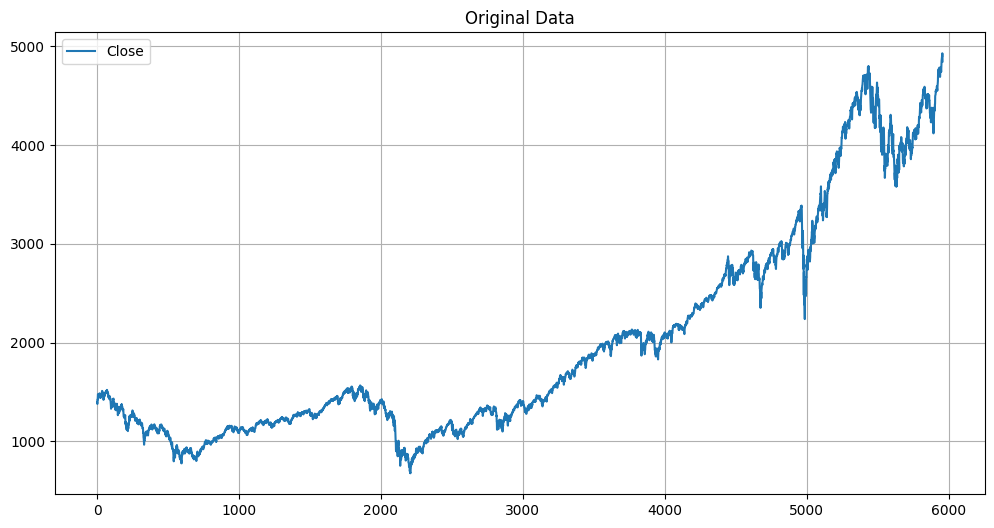

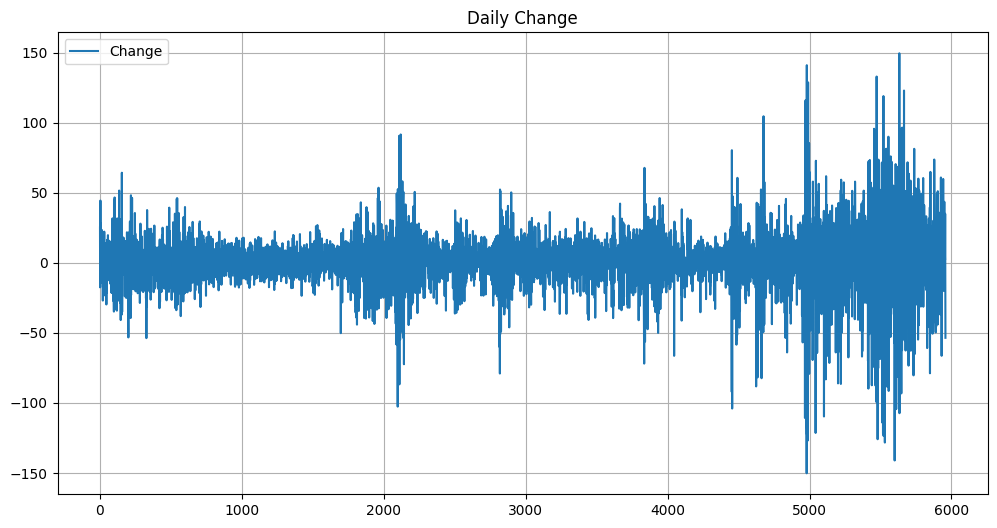

In [3]:
data = prepare_data(SP500_TICKER)


# Show data
print(data.shape)
print(data.dtypes)
# Save the plot as an image with 50x50 pixels

# Show the plot
# plt.show()
# plt.show()

plt = config_chart('Original Data')
plt.plot(data.Close)
plt.legend(['Close'])

plt = config_chart('Daily Change')
plt.plot(data.Change)
plt.legend(['Change'])

data

---

## For **generateImages** function

In [4]:
# generateImages(data)


---

## For **getImages** function

Found 990 images belonging to 5 classes.


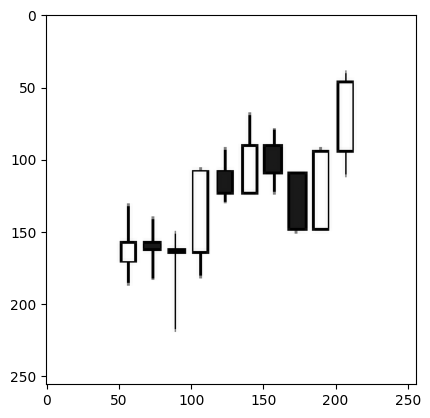

In [5]:
images = getImages()

img = images.__next__()[0]
img.shape
plt.imshow(img[4] / 255.0)

---

## For **getClassesAndFiles** function

In [6]:
classes, folders = getClassesAndFiles()

print(len(folders))
classes


5


['bearish_reverse',
 'bearish_trend',
 'bullish_reverse',
 'bullish_trend',
 'neutral']

---

## For **getClassesAndFiles** function

In [7]:
all_files, all_class_ids = mapAllClassesAndImages(classes, folders)

print(len(all_files))
print(all_files[0])

print(len(all_class_ids))
print(all_class_ids[0])

990
models/cnn_v3/data/bearish_reverse\2000-06-20.png
990
0


---

## For **getImagesDataset** function

990
4


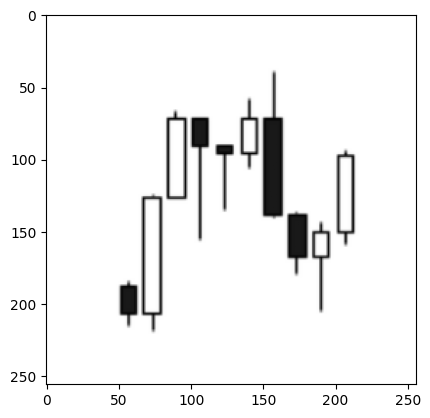

In [8]:
dataset = getImagesDataset(all_files, all_class_ids)

print(tf.data.experimental.cardinality(dataset).numpy())
# print(list(len(dataset)))

for el in dataset.take(1):
    # print(el)
    # print(el[0].numpy(), el[1].numpy())
    print(el[1][0].numpy())
    plt.imshow(el[0][0].numpy())

# dataset


---

## For **split_train_and_test_data** function

In [9]:
train_dataset, test_dataset, predict_dataset = split_train_and_test_data(dataset)

print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())
print(tf.data.experimental.cardinality(predict_dataset).numpy())

693
198
99


---

## For **get_lstm_data** function

In [10]:
train, test, predict = get_cnn_data(SP500_TICKER)

In [11]:

print(train)
print(tf.data.experimental.cardinality(train).numpy())
# print(tf.data.experimental.cardinality(test_dataset).numpy())
# print(tf.data.experimental.cardinality(predict_dataset).numpy())

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
693


In [12]:
print(test)
print(tf.data.experimental.cardinality(test).numpy())


<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
198


In [13]:
print(predict) 
print(tf.data.experimental.cardinality(predict).numpy())

<_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
99


In [14]:
# num_columns = predict["x"].shape[1]  # Get the number of columns

# index = 20

# plt = config_chart('Model Data')
# plt.plot(predict['x_dates'][0:index], predict["x"][:, 0][0:index])
# plt.plot(predict['x_dates'][0:index], predict["x"][:, 1][0:index])
# plt.plot(predict['x_dates'][0:index], predict["x"][:, 2][0:index])
# plt.plot(predict['x_dates'][0:index], predict["x"][:, 3][0:index])
# # plt.title(f'Column {i+1}')
# plt.xlabel('Index')
# plt.ylabel('Value')

# plt.grid(True)  # Add grid
# plt.tight_layout()
# plt.savefig('stock_price_50x50.png', dpi=100)  # Save as PNG image with 100 DPI
# plt.close()

# plt.grid(True)
# plt.show()


TypeError: '_SkipDataset' object is not subscriptable

In [ ]:
# BASE_DIR = "models/cnn_v3/data/"

# generator = ImageDataGenerator()

# images = generator.flow_from_directory(BASE_DIR)

# img = images.__next__()[0]
# img.shape

# plt.imshow(img[4] / 255.0)

# Dataset.from_tensor_slices([1,2,3])

# classes = os.listdir(BASE_DIR)
# folders = [BASE_DIR + class_name for class_name in classes]

# print(classes)

# all_files = []
# print(folders)
# all_classes = []

# for folder_name, class_name in zip(folders, classes):
#     files = os.listdir(folder_name)
#     all_files.extend([os.path.join(folder_name, file) for file in files])
#     all_classes.extend([class_name] * len(files))

# print(len(all_files))
# print(len(all_classes))

# class_mapping = {class_name: class_id for (class_id, class_name) in list(enumerate(classes))}

# all_class_ids = [class_mapping[c] for c in all_classes]

# def read_images(file_name, class_name):
#     image_file = tf.io.read_file(file_name)
#     image = tf.image.decode_png(image_file)
#     image_scaled = tf.cast(image, float) / 255.0
#     image_resized = tf.image.resize(image_scaled, (256, 256))
#     return (image_resized, class_name)

# dataset = Dataset.from_tensor_slices((all_files, all_class_ids)).shuffle(len(all_files)).map(read_images).batch(4).repeat()


# for el in dataset.take(1):
#     print(el[0].numpy(), el[1].numpy())
# model = Sequential([
#         Input((256, 256, 4)),
#         Conv2D(filters=32, kernel_size=(3, 4), activation='relu'),
#         Conv2D(filters=16, kernel_size=(3, 4), activation='relu'),
#         Conv2D(filters=8, kernel_size=(3, 4), activation='relu'),
#         Flatten(),
#         Dense(units=32, activation='relu'),
#         Dense(units=5, activation='softmax')
#     ])

# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
# model.fit(dataset, epochs=10, steps_per_epoch=len(all_files) // 4)

